## Example 6 – Replication of Habit Model in Wachter (2006) in Continuous Time
### Time-Varying Surplus Consumption Ratio
This example replicates some main results from Wachter (2006) as adapted to continuous time. The results replicated are the yields of real bonds and the price-consumption ratio. The state variable in the model is the surplus consumption ratio, which is part of the utility function. It evolves according to:

$$
\mathrm{d}s_t=-\log\phi(\bar{s}-s_t)\mathrm{d}t+\lambda(s_t)\sigma_{c}\mathrm{d}W_{t}
$$

The modified state variable for the calculation of yields evolves according to:

$$
\mathrm{d}\hat{s}_t=\Big(-\log\phi(\bar{s}-\hat{s}_t)-\gamma \sigma_c^2\lambda(\hat{s}_t)-\gamma \sigma_c^2\lambda(\hat{s}_t)^2\big) \Big)\mathrm{d}t+\lambda(\hat{s}_t)\sigma_c\mathrm{d}W_{t}
$$


And the modified state variable and short rate for the calculation of the price-consumption ratio evolves according to:

$$
\mathrm{d}\tilde{s}_t=\Big(-\log\phi(\bar{s}-\gamma\tilde{s}_t)+\lambda(\tilde{s}_t)\sigma_{c}+\Big)\mathrm{d}t+\lambda(\tilde{s}_t)\sigma_c\mathrm{d}W_{t}
$$
$$
\tilde{r}(\tilde{s}_t)=\rho+\gamma\log(\phi)\tilde{s}_t+\gamma \mu_c-\frac{\gamma^2\sigma_c^2}{2}\big(1+\lambda(s)\big)^2-\mu_c-\sigma_c^2\lambda(\tilde{s}_t)
$$

In order to get the price of the zero-coupon security price-consumption ratio, two processes for the integrals of the short-term rate, unmodified and modified, will also be needed:

$$
\mathrm{d}\mathcal{I}_1 = r(\hat{x}_t)\mathrm{d}t
$$
$$
\mathrm{d}\mathcal{I}_2 = \tilde{r}(\tilde{x}_t)\mathrm{d}t
$$

##### Import the packages

In [1]:
import SDFPricing as sdf
import StochasticDiffEq as sde # this is needed in order to specify the algorithm

#### Define the parameters

In [2]:
# #? parameters from Wachter (2006) paper
# cs = (
#     phi = 0.97, # mean reversion
#     gamma = 2.0, # risk aversion
#     b = 0.011, 
#     xbar = 0.0, # long-run mean
#     rho = -log(0.98), # time preference parameter
#     muc0 = 0.00549, # consumption drift
#     sigmac = 0.00431, # consumption diffusion
#     rhocx = 1.0, # correlation between consumption and state variable
#     sigmaD = 0.00431, # dividend diffusion ###- case of consumption perpetuity
#     muD = 0.00549, # dividend drift ###- case of consumption perpetuity
#     rhoxD = 1.0, # correlation between dividends and state variable ###- case of consumption perpetuity
#     rhocD = 1.0 # correlation between dividends and consumption ###- case of consumption perpetuity
# );

# #? parameters from Wachter (2006) paper
# cs = (
#     phi = 0.89, # mean reversion
#     gamma = 2.0, # risk aversion
#     b = 0.011, 
#     xbar = 0.0, # long-run mean
#     rho = -log(0.93), # time preference parameter
#     muc0 = 0.022, # consumption drift
#     sigmac = 0.0086, # consumption diffusion
#     rhocx = 1.0, # correlation between consumption and state variable
#     sigmaD = 0.0086, # dividend diffusion ###- case of consumption perpetuity
#     muD = 0.022, # dividend drift ###- case of consumption perpetuity
#     rhoxD = 1.0, # correlation between dividends and state variable ###- case of consumption perpetuity
#     rhocD = 1.0 # correlation between dividends and consumption ###- case of consumption perpetuity
# );


#? parameters from Campbell Cochrane (1999) paper
cs = (
    phi = 0.87, # mean reversion
    gamma = 2.0, # risk aversion
    b = 0.0, 
    xbar = 0.0, # long-run mean
    rho = -log(0.895), # time preference parameter
    muc0 = 0.0189, # consumption drift
    sigmac = 0.015, # consumption diffusion
    rhocx = 1.0, # correlation between consumption and state variable
    sigmaD = 0.015, # dividend diffusion ###- case of consumption perpetuity
    muD = 0.0189, # dividend drift ###- case of consumption perpetuity
    rhoxD = 1.0, # correlation between dividends and state variable ###- case of consumption perpetuity
    rhocD = 1.0 # correlation between dividends and consumption ###- case of consumption perpetuity
);

#### Drift and Diffusion of the processes
I also include the unmodified process which will correspond to "risk-neutral pricing". By comparing normal pricing with risk-neutral pricing it is possible to compute excess returns.

In [3]:
###- now consumption diffusion is a non-linear function of the state, 
###- given that it needs to be positive.
###- I use this function because the simple exponential can get too high for some samples.
Sbar = cs.sigmac*(cs.gamma/(-log(cs.phi)-cs.b/cs.gamma))^(1/2);
# Sbar = cs.sigmac*(cs.gamma/(1-cs.phi-cs.b/cs.gamma))^(1/2);
lambda(x) = x<(1-Sbar^2)/2 ? (1-2*x)^(1/2)/Sbar-1 : 0;
sigmac(x,c) = c.sigmac;
sigmac(x) = sigmac(x,cs); 
sigmaL(x) = -cs.gamma*sigmac(x)*(1+lambda(x)) 
# sigmaD(x,c) = defineSomeFunctionOf(x,c); #- general dividend diffusion
sigmaD(x,c) = sigmac(x,c); #- case of consumption perpetuity
sigma(x,c) = sigmac(x)*lambda(x); # diffusion of modified state
mu00(x,c) = -log(c.phi)*(c.xbar-x); # drift of unmodified state
mu0(x,c) = mu00(x,c)+c.rhocx*sigma(x,c)*sigmaL(x); # drift of modified state for yield
# drift of modified state for price consumption ratio
mu(x,c) = mu0(x,c)+c.rhoxD*sigma(x,c)*sigmaD(x,c); 

In [4]:
Sbar
-log(cs.phi)

0.13926206733350766

In [5]:
# plt.plot(xRange, r.(xRange))
# plt.plot!(xRange, -cs.b.*xRange)
# plt.plot!(xRange, r.(xRange).+cs.b.*xRange.-r(0.0))

#### Short-term rate function

In [6]:
r(x,c) = c.rho+c.gamma*log(c.phi)*x+c.gamma*c.muc0-sigmaL(x)^2/2;
# r(x,c) = c.rho+c.gamma*(c.phi-1)*x+c.gamma*c.muc0-c.gamma^2*c.sigmac^2/2*(1+lambda(x))^2;
r(x) = r(x,cs);
muD(x) = cs.muD; # perpetuity with constant dividend drift
rmod(x,c) = r(x,c)-muD(x)-c.rhocD*sigmaD(x,c)*sigmaL(x);
rmod(x) = rmod(x,cs);

In [7]:
(r(0.0),r(0.1))

(0.009469493373774063, 0.009469493373773993)

In [8]:
cs.rho+cs.gamma*cs.muc0-(cs.gamma*(-log(cs.phi))-cs.b)/2

0.009469493373774007

In [9]:
delta=0.89
gamma=2.0
phi=0.87
gg=0.0189
-log(delta)+gamma*gg-gamma*(1-phi)/2

0.02433381625595149

In [10]:
(1+0.00094)^12

1.011338500715532

In [11]:
delta=0.89^(1/12)
gamma=2.0
phi=0.87^(1/12)
gg=0.0189/12
12*(-log(delta)+gamma*gg-gamma*(1-phi)/2)

0.015876712142620014

In [12]:
cs.rho+cs.gamma*cs.muc0-cs.gamma*(-log(cs.phi))/2

0.009469493373774007

In [13]:
cs.b

0.0

#### Define setup consistent with SDE solution in Julia

In [14]:
function drift(du,u,p,t,c)
    du[1] = mu0(u[1],c)
    du[2] = mu(u[2],c)
    du[3] = r(u[1],c)
    du[4] = rmod(u[2],c)
end
drift(du,u,p,t) = drift(du,u,p,t,cs);
function diffusion(du,u,p,t,c)
    du[1] = sigma(u[1],c)
    du[2] = sigma(u[2],c)
    du[3] = 0.0
    du[4] = 0.0
end
diffusion(du,u,p,t) = diffusion(du,u,p,t,cs);

#### Define the Problem and SolutionSettings variables

In [15]:
prob = sdf.Problem(drift=drift,diffusion=diffusion,numNoiseVariables=1,outVariables=[3,4],
terminalFunction=(ik, x, y, z) -> exp(-x));
xRange = -0.5:0.15:0.5;
# tRange = 0.0:0.5:600.0;
tRange = 0.0:5.:90.0;

sett = sdf.SolutionSettings(xRanges=[xRange,], initialValues=[[x,x,0.0,0.0] for x in xRange], 
algorithm=sde.EulerHeun(), pathsPerInitialValue=1000, tRange=tRange,dt=0.005);
# add the settings in order to compmute price-dividend ration of the continuous payoff security
sett2 = sdf.SolutionSettings(sett; continuousPayoffVars=[4]);

#### Solve Problem and Define Yield

In [16]:
# ((consumptionStrip,),(priceConsumptionRatio,)) = sdf.solve(prob, sett2);
(singlePayoff,continuousPayoff) = sdf.solve(prob, sett2);
yld1(t,x) = -log(singlePayoff[1](t,x))/(t);
yld2(t,x) = -log(singlePayoff[2](t,x))/(t);

#### Plot the yield

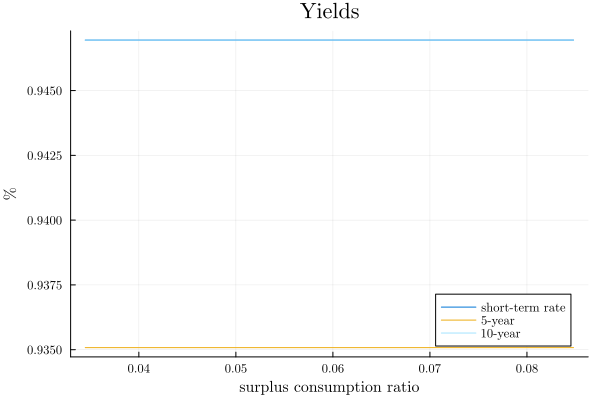

In [17]:
# colors: "#0075d6", "#edad14", "#a3e3ff", "#9c0000"
import Plots as plt
plt.default(titlefont= (14,"Computer Modern"),legendfont=(8,"Computer Modern"),
    tickfont=(8,"Computer Modern"),guidefont=(10,"Computer Modern"))
plt.plot(Sbar.*exp.(xRange), xRange .|> x->100*r(x), title="Yields",
    xlabel="surplus consumption ratio",label="short-term rate",color="#0075d6",ylabel="%")
# plt.plot!(Sbar.*exp.(xRange), xRange .|> x->100*((1+r(x))^4-1), title="Yields",
#     xlabel="surplus consumption ratio",label="short-term rate",color="#9c0000",ylabel="%")
plt.plot!(Sbar.*exp.(xRange), 100*yld1.(0.25, xRange), label="5-year",color= "#edad14")
plt.plot!(Sbar.*exp.(xRange), 100*yld1.(5., xRange), label="10-year",color="#a3e3ff")

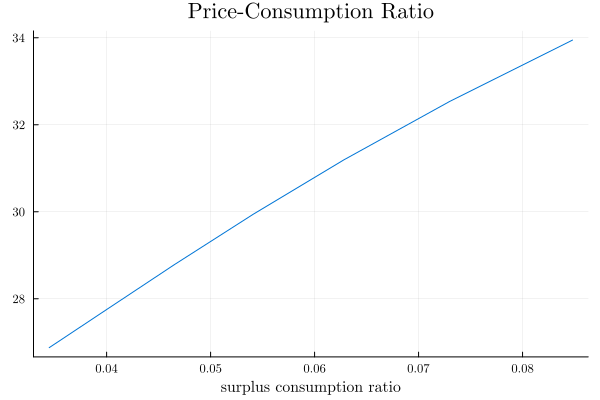

In [27]:
import Plots as plt
plt.default(titlefont= (14,"Computer Modern"),legendfont=(8,"Computer Modern"),
    tickfont=(8,"Computer Modern"),guidefont=(10,"Computer Modern"))
plt.plot(Sbar.*exp.(xRange), continuousPayoff[1](xRange), legend=false,
    title="Price-Consumption Ratio",color="#0075d6", xlabel="surplus consumption ratio")

In [19]:
singlePayoff[2](90,0.4)

9.130552014000502e-6

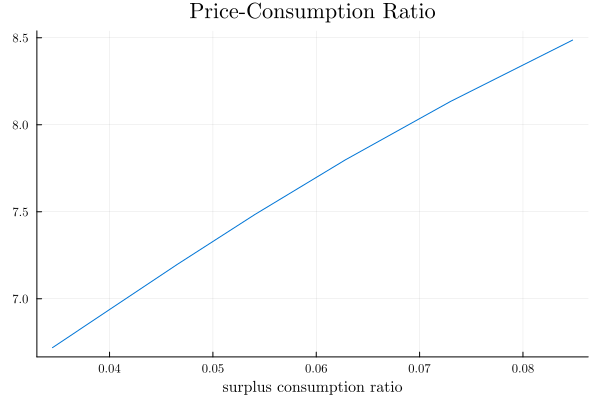

In [28]:
import Plots as plt
plt.default(titlefont= (14,"Computer Modern"),legendfont=(8,"Computer Modern"),
    tickfont=(8,"Computer Modern"),guidefont=(10,"Computer Modern"))
plt.plot(Sbar.*exp.(xRange), continuousPayoff[1](xRange)/4, legend=false,
    title="Price-Consumption Ratio",color="#0075d6", xlabel="surplus consumption ratio")

In [21]:
continuousPayoff[1](0.0)

30.34626583834764

In [22]:
(1+r(.0))^4-1

0.038419405931879425

In [23]:
Sbar*exp(0)

0.05684468155648369

In [24]:
r(0.0)

0.009469493373774063

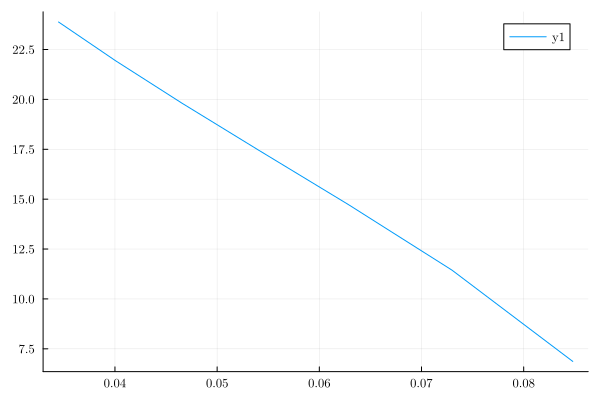

In [25]:
xRange
plt.plot(Sbar.*exp.(xRange), lambda.(xRange))

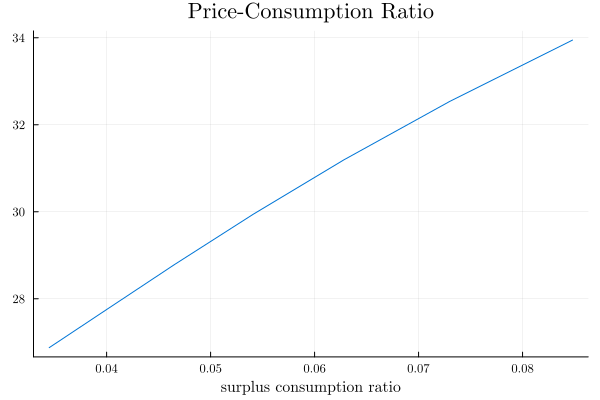

In [26]:
import Plots as plt
plt.default(titlefont= (14,"Computer Modern"),legendfont=(8,"Computer Modern"),
    tickfont=(8,"Computer Modern"),guidefont=(10,"Computer Modern"))
plt.plot(Sbar.*exp.(xRange), continuousPayoff[1](xRange), legend=false,
    title="Price-Consumption Ratio",color="#0075d6", xlabel="surplus consumption ratio")